# Benchmarking simulation tests 
Simple integration tests where certain results are expected and will be compared to theory.

In [1]:
BOLTZMAN_CONSTANT = 1.38064e-23 # J K−1

# 1st : theoretical collision frequency for MB distribution
def collision_frequency_th_T(T, m, d, n): # per unit of volume and time
    return 0.5*n*4*np.sqrt(BOLTZMAN_CONSTANT*T/m)*d*d*n

def energy(arr, mass): # arr of velocities - shape n x 3
    return 0.5*mass*np.sum(np.linalg.norm(arr, axis =1)**2)

In [2]:
%matplotlib notebook

# system
from src.system_creator import SystemCreator

# Grid
from src.utils import Grid, pos_in_grid, convert_to_grid_datatype

# Particles
from src.utils import Particle

# injection 
from src.utils import inject

# advection
from src.utils import advect
from src.utils import euler_explicit, leap_frog

# collisions
from src.utils import handler_wall_collision, handler_wall_collision_point, make_collisions_vectorized, make_collisions_out_walls, deal_with_corner

# utils 
from src.utils import gaussian, maxwellian_flux, maxwellian_mean_speed, get_mass_part, mean_free_path, mean_free_time

# systems
from src.utils import thruster

# plotting 
from src.plotting import plot_boundaries, plot_particles, plot_grid, plot_system

# collisions between particles
from src.utils import handler_particles_collisions, candidates # candidates, index_choosen_couples, probability, is_colliding, reflect, 

# other imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# from icecream import ic
import pandas as pd
# import seaborn as sns
import os
np.random.seed(1111)

## Defining the system

In [3]:
# Square System :
dz = 0.001
idx_out_walls = [] # no out walls

segments = 0.001*3*np.array([[0,0,1,0], [0,0,0,1], [1,0,1,1], [0,1,1,1]]) # tube
system = SystemCreator(segments)

offsets = system.get_offsets()
system_shape = system.system_shape()
a = system.get_dir_vects()
segments = system.get_segments()
extremal_values = system.get_extremal_values()

## Simulation params

In [4]:
dt = 5e-7 # in sec, should be a fraction of the mean free time

# advection
def f(arr, dt):
    return np.zeros(shape = (arr.shape[0], 3))
args = []
scheme = euler_explicit

## Thermalisation

An array of particle initialized randomly on the square with uniform speed is constructed and immediately given to the container for particles.

In [5]:
# Grid :
mean_number_per_cell = 1000
max_number_per_cell = 10*mean_number_per_cell
resolutions = np.array((3,3), dtype = int)

grid = Grid(resolutions, max_number_per_cell)
volume_cell = dz * system_shape[0]/resolutions[0] * system_shape[1]/resolutions[1]

# Density of the gas
density = 3.2e19 # m-3
n_simu = mean_number_per_cell*np.prod(resolutions) # number of particles in the simulated system
n_real = volume_cell * density * np.prod(resolutions) # number of particles in the real system
mr = n_real/n_simu # macro particules ratio = number of particles in the real system / number of macro part in the simulated system
density_dsmc = density/mr

# Particles
part_type = 'I'
charge, mass, radius = 0, get_mass_part(53, 53, 74), 2e-10

# Array
size_array = mean_number_per_cell*np.prod(resolutions) # 2* # we take exactly the right size

print(f'Number of particles : {size_array}')

min_vel, max_vel = -200, 200
x = np.random.uniform(low = extremal_values['min_x'], high = extremal_values['max_x'], size = size_array)
y = np.random.uniform(low = extremal_values['min_y'], high = extremal_values['max_y'], size = size_array)
vx = np.random.uniform(low = min_vel, high = max_vel, size = size_array)
vy = np.random.uniform(low = min_vel, high = max_vel, size = size_array)
vz = np.random.uniform(low = min_vel, high = max_vel, size = size_array)
arr = np.stack((x,y,vx,vy,vz), axis = 1) 

arr_save = np.copy(arr)

container = Particle(part_type, charge, mass, radius, size_array)
container.add_multiple(arr)
cross_section = container.get_params()[3]

# Energy in the system :
nrj = energy(arr, mass)
target_temperature = (2*nrj/size_array)/(3*BOLTZMAN_CONSTANT)
print(f'Energy in the system : {nrj} J')
print(f'Should relax toward the temperature : {target_temperature} K')

Number of particles : 9000
Energy in the system : 3.7849849184839425e-17 J
Should relax toward the temperature : 203.07194722812085 K


### Simulation

In [6]:
# NAME tests
from pathlib import Path

dir_path = Path('results/benchmark/thermalization')

name_df = dir_path/'df.h5'
name_coll = dir_path/'collisions.npy'
name_monitor_dsmc = dir_path/'monitor-dsmc.npy'
name_pmax = dir_path/'pmaxes-evo.npy'
name_average = dir_path/'averages-evo.npy'

if(os.path.exists(dir_path)):
    os.system('rm -f -r {}'.format(dir_path))
os.makedirs(dir_path)

In [ ]:
iterations = 10000

store = pd.HDFStore(name_df)

df = pd.DataFrame(columns = ['x','y','vx','vy','vz'])

remains = 0
saving_period = 100

averages = np.full(shape = grid.current.shape, fill_value = mean_number_per_cell)
pmax = 2*np.mean(np.linalg.norm(arr[:,2:], axis = 1))*cross_section*np.ones(averages.shape)
remains_per_cell = np.zeros(shape = grid.current.shape, dtype = float)

# dsmc saving
averages_evo = np.zeros((iterations, averages.shape[0], averages.shape[1]))
pmax_evo = np.zeros((iterations, pmax.shape[0], pmax.shape[1]))
arr_nb_colls = np.zeros((iterations, resolutions[0], resolutions[1]))
monitors = np.zeros((iterations, 3))

print('|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|'.format(' it ', ' INIT ', ' INJECT ', ' DEL ', ' TRY'))
print('{:-^56}'.format(''))

for it in range(iterations): # tqdm
    n1 = container.get_current()
                   
    # injecting particles - no injection
    # new, remains = inject(in_wall, in_vect, debit, vel_std, radius, dt, remains)
    # container.add_multiple(new)
                   
    n2 = container.get_current()-n1
    
    # PHASE : ADVECTING
        # MOVING PARTICLES
    arr = container.get_particles()
    
    df = df.append(pd.DataFrame(data=arr, index=[it]*arr.shape[0], columns = ['x','y','vx','vy','vz']))
    
    advect(arr, f, dt, args, scheme) # advect is inplace
    
        # HANDLING BOUNDARIES 
    arr_save = np.copy(arr)
    count = np.full(fill_value = True, shape = arr.shape[0])
    idxes_out = []
    c = 0
    while(np.sum(count, where = count == True) > 0):
        c+=1
        ct, cp = handler_wall_collision_point(arr[count], segments, a) # handler_wall_collision(arr[count], segments, a, radius)
        count, idxes_out_ = make_collisions_out_walls(arr, a, ct, cp, idx_out_walls, count) # idxes_out : indexes of the particles (in arr) that got out of the system
        idxes_out.append(idxes_out_)
    
    idxes_out = np.concatenate(idxes_out)
    # no need to delete anything (in theory)
    # container.delete_multiple(idxes_out)
    # arr = container.get_particles()
    
    # PHASE : COLLISIONS
        # UPDATING GRID - HARD RESET
    grid.reset()
    positions = pos_in_grid(arr[:,:2], resolutions, offsets, system_shape)
    particles = convert_to_grid_datatype(positions, new = positions.shape[0])
    grid.add_multiple(particles)

        # DSMC
        # TODO: make parallel
    currents = grid.get_currents()
    averages = (it*averages+currents)/(it+1) # may be it too violent ? 
    
    # saving for plotting later on
    pmax_evo[it,:,:] = pmax[:,:]
    averages_evo[it, :, :] = averages[:,:]
    
    remains_per_cell, nb_colls, new_pmax, monitor = handler_particles_collisions([arr], grid.get_grid(), currents, dt, averages, pmax, cross_section, volume_cell, mr, remains_per_cell, monitoring = True)
    monitors[it] = monitor
    arr_nb_colls[it,:,:] = nb_colls
    
    # PLOTTING AND SAVING (OPTIONAL)
    if(it%saving_period==0):
        store.append('df', df)
        df = pd.DataFrame(columns = ['x','y','vx','vy','vz']) # this way not too much memory is used
        print('|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|'.format(it, n1, n2, idxes_out.shape[0], c))
   
# saving back
np.save(file = name_monitor_dsmc, arr = monitors, allow_pickle=False)
np.save(file = name_coll, arr = arr_nb_colls, allow_pickle=False)
np.save(file = name_pmax, arr = pmax_evo, allow_pickle=False)
np.save(file = name_average, arr = averages_evo, allow_pickle=False)
store.append('df', df)
store.close()

### Analysis

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# opening dataframe and array
store = pd.HDFStore(name_df)
df = store['df']
arr_nb_colls = np.load(name_coll)
monitors = np.load(name_monitor_dsmc)

<IPython.core.display.Javascript object>


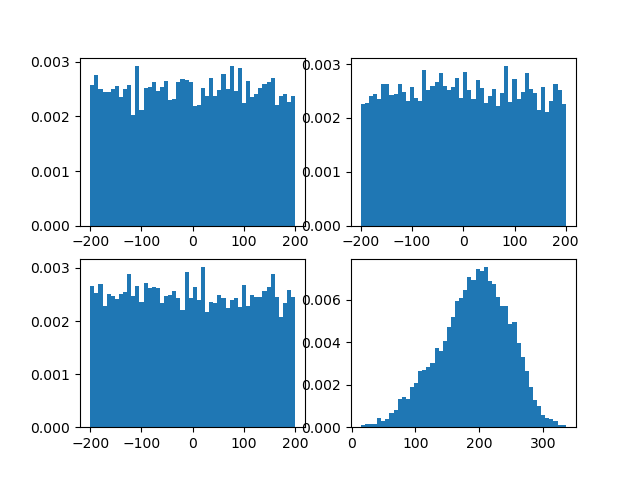

In [11]:
# towards the end 
%matplotlib notebook
fig, ax = plt.subplots(2,2)
iterations_list = [k for k in range(0,1)]
df_it = df.loc[np.isin(df.index,iterations_list)]
ax[0,0].hist(df_it['vx'], bins = 50, density = True)
ax[0,1].hist(df_it['vy'], bins = 50, density = True)
ax[1,0].hist(df_it['vz'], bins = 50, density = True)
ax[1,1].hist(np.sqrt(df_it['vx']**2+df_it['vy']**2+df_it['vz']**2), bins = 50, density = True);

<IPython.core.display.Javascript object>


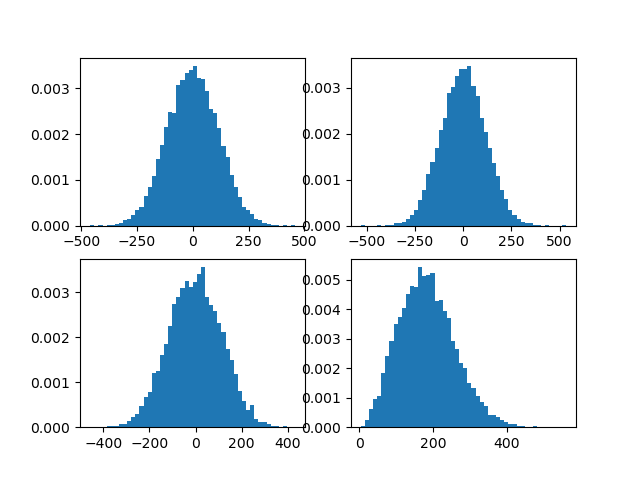

In [10]:
# towards the end 
%matplotlib notebook
fig, ax = plt.subplots(2,2)
iterations_list = [k for k in range(1900,2000)]
df_it = df.loc[np.isin(df.index,iterations_list)]
ax[0,0].hist(df_it['vx'], bins = 50, density = True)
ax[0,1].hist(df_it['vy'], bins = 50, density = True)
ax[1,0].hist(df_it['vz'], bins = 50, density = True)
ax[1,1].hist(np.sqrt(df_it['vx']**2+df_it['vy']**2+df_it['vz']**2), bins = 50, density = True);

In [12]:
def variance(vx, vy, vz):
    norms = np.sqrt(vx*vx+vy*vy+vz*vz) # N particles - shape : N
    mean = np.mean(norms)
    return np.mean((norms - mean)**2)

In [17]:
step = 100
var_evo = np.array([variance(df.loc[df.index==k]['vx'], df.loc[df.index==k]['vy'], df.loc[df.index==k]['vz']) for k in range(0,iterations,step)])

In [18]:
var_evo.shape

(100,)

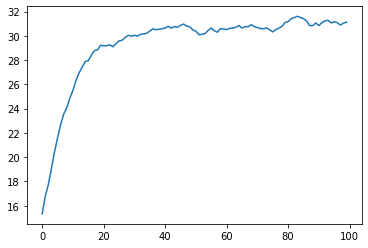

In [19]:
%matplotlib inline
plt.plot(var_evo*mass/(3*BOLTZMAN_CONSTANT))
plt.show()

In [20]:
# We can then try to minimize a given function 
a = np.sqrt(BOLTZMAN_CONSTANT*target_temperature/mass) # mean speed at the end (not the most likely one in theory)
sigma_eq = a*a*(3*np.pi-8)/np.pi
print(f'Variance at equilibrium (MB distribution) : {sigma_eq}')

Variance at equilibrium (MB distribution) : 5986.720289895263


In [21]:
from scipy.optimize import least_squares

# loss function (to minimize)
def loss_fn(X, var_arr, init_var, eq_var, times):
    # X = [tau] 
    # forced to use a list though
    tau = X[0]
    return np.sum(np.abs(var_arr-(init_var-eq_var)*np.exp(-times/tau)-eq_var))


In [22]:
tau_init = 1e-3 
var_arr = var_evo
init_var = var_arr[0]
eq_var = sigma_eq

# times
t_init = 0
times = np.array([t_init+k*dt for k in range(0,iterations,step)])

In [23]:
results = least_squares(loss_fn, np.array([tau_init]), bounds = ([1e-3*tau_init],[1e3*tau_init]), args = (var_arr,init_var,eq_var,times)).x
tau = results[0]

print(tau)

0.00045767490984787275


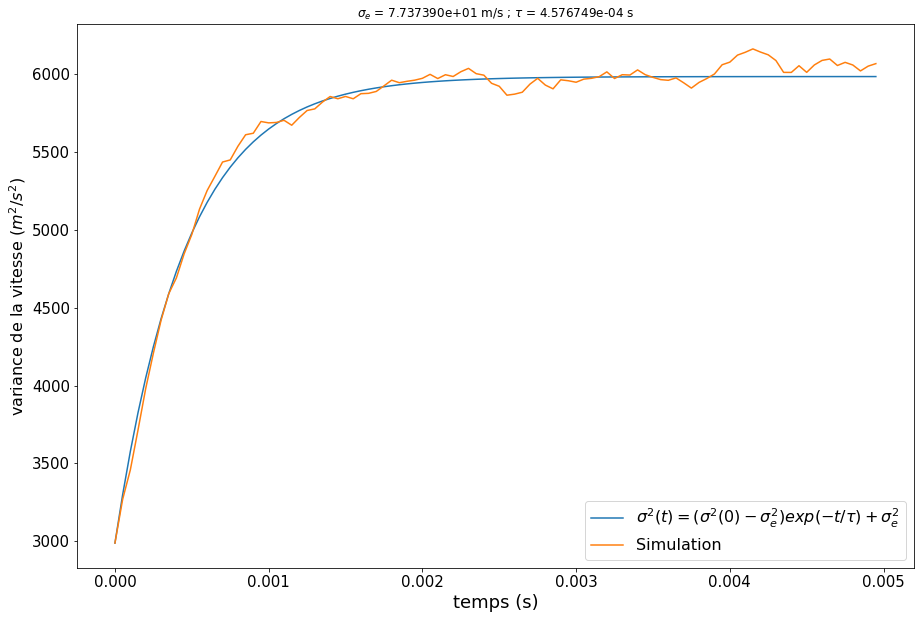

In [24]:
def get_Temp(times):
    return (init_var-eq_var)*np.exp(-times/tau)+eq_var


fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("$\sigma_e$ = {} m/s ; $\\tau$ = {} s".format("{:e}".format(np.sqrt(eq_var)),"{:e}".format(tau)))
plt.xlabel("temps (s)",fontsize=18)
plt.ylabel("variance de la vitesse ($m^2/s^2$)",fontsize=16)

plt.plot(times, get_Temp(times), label = '$\sigma^2(t) = (\sigma^2(0)-\sigma^2_e)exp(-t/\\tau)+\sigma^2_e$')
plt.plot(times,var_arr, label = 'Simulation')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.plot(listTime,Temp_smooth)
plt.legend(loc='best',fontsize=16)


## Number of collisions

In [30]:
# Grid :
mean_number_per_cell = 1000
max_number_per_cell = 10*mean_number_per_cell
resolutions = np.array((3,3), dtype = int)

grid = Grid(resolutions, max_number_per_cell)
volume_cell = dz * system_shape[0]/resolutions[0] * system_shape[1]/resolutions[1]

# Density of the gas
density = 3.2e19 # m-3
n_simu = mean_number_per_cell*np.prod(resolutions) # number of particles in the simulated system
n_real = volume_cell * density * np.prod(resolutions) # number of particles in the real system
mr = n_real/n_simu # macro particules ratio = number of particles in the real system / number of macro part in the simulated system
density_dsmc = density/mr

# Particles
part_type = 'I'
charge, mass, radius = 0, get_mass_part(53, 53, 74), 2e-10

# Array
size_array = mean_number_per_cell*np.prod(resolutions) # 2* # we take exactly the right size
print(f'Number of particles : {size_array}')

temperature = 300 # K
loc = 0
vel_std = gaussian(temperature, mass)
x = np.random.uniform(low = extremal_values['min_x'], high = extremal_values['max_x'], size = size_array)
y = np.random.uniform(low = extremal_values['min_y'], high = extremal_values['max_y'], size = size_array)
vx = np.random.normal(loc=0.0, scale=vel_std, size = size_array)
vy = np.random.normal(loc=0.0, scale=vel_std, size = size_array)
vz = np.random.normal(loc=0.0, scale=vel_std, size = size_array)
arr = np.stack((x,y,vx,vy,vz), axis = 1) 

arr_copy = np.copy(arr)

container = Particle(part_type, charge, mass, radius, size_array)
container.add_multiple(arr)
cross_section = container.get_params()[3]

# Energy in the system :
nrj = energy(arr, mass)

print(f'Energy in the system : {nrj} J')
T_exp = (2*nrj/size_array)/(3*BOLTZMAN_CONSTANT)
print(f'Should relax toward the temperature : {T_exp} K')

Number of particles : 9000
Energy in the system : 5.593374370655918e-17 J
Should relax toward the temperature : 300.095627720473 K


In [19]:
# NAME tests
from pathlib import Path

dir_path = Path('results/benchmark/nb-collisions')

name_df = dir_path/'df.h5'
name_coll = dir_path/'collisions.npy'
name_monitor_dsmc = dir_path/'monitor-dsmc.npy'
name_pmax = dir_path/'pmaxes-evo.npy'
name_average = dir_path/'averages-evo.npy'

if(os.path.exists(dir_path)):
    os.system('rm -f -r {}'.format(dir_path))
os.makedirs(dir_path)

In [ ]:
iterations = 2000
store = pd.HDFStore(name_df)

df = pd.DataFrame(columns = ['x','y','vx','vy','vz'])

remains = 0
saving_period = 100

averages = np.full(shape = grid.current.shape, fill_value = mean_number_per_cell)
pmax = 2*np.mean(np.linalg.norm(arr[:,2:], axis = 1))*cross_section*np.ones(averages.shape)
remains_per_cell = np.zeros(shape = grid.current.shape, dtype = float)

# dsmc saving
averages_evo = np.zeros((iterations, averages.shape[0], averages.shape[1]))
pmax_evo = np.zeros((iterations, pmax.shape[0], pmax.shape[1]))
arr_nb_colls = np.zeros((iterations, resolutions[0], resolutions[1]))
monitors = np.zeros((iterations, 3))

print('|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|'.format(' it ', ' INIT ', ' INJECT ', ' DEL ', ' TRY'))
print('{:-^56}'.format(''))

for it in range(iterations): # tqdm
    n1 = container.get_current()
                   
    # injecting particles - no injection
    # new, remains = inject(in_wall, in_vect, debit, vel_std, radius, dt, remains)
    # container.add_multiple(new)
                   
    n2 = container.get_current()-n1
    
    # PHASE : ADVECTING
        # MOVING PARTICLES
    arr = container.get_particles()
    
    df = df.append(pd.DataFrame(data=arr, index=[it]*arr.shape[0], columns = ['x','y','vx','vy','vz']))
    
    advect(arr, f, dt, args, scheme) # advect is inplace
    
        # HANDLING BOUNDARIES 
    arr_save = np.copy(arr)
    count = np.full(fill_value = True, shape = arr.shape[0])
    idxes_out = []
    c = 0
    while(np.sum(count, where = count == True) > 0):
        c+=1
        ct, cp = handler_wall_collision_point(arr[count], segments, a) # handler_wall_collision(arr[count], segments, a, radius)
        count, idxes_out_ = make_collisions_out_walls(arr, a, ct, cp, idx_out_walls, count) # idxes_out : indexes of the particles (in arr) that got out of the system
        idxes_out.append(idxes_out_)
    
    idxes_out = np.concatenate(idxes_out)
    # no need to delete anything (in theory)
    # container.delete_multiple(idxes_out)
    # arr = container.get_particles()
    
    # PHASE : COLLISIONS
        # UPDATING GRID - HARD RESET
    grid.reset()
    positions = pos_in_grid(arr[:,:2], resolutions, offsets, system_shape)
    particles = convert_to_grid_datatype(positions, new = positions.shape[0])
    grid.add_multiple(particles)

        # DSMC
        # TODO: make parallel
    currents = grid.get_currents()
    averages = (it*averages+currents)/(it+1) # may be it too violent ? 
    
    # saving for plotting later on
    pmax_evo[it,:,:] = pmax[:,:]
    averages_evo[it, :, :] = averages[:,:]
    
    remains_per_cell, nb_colls, new_pmax, monitor = handler_particles_collisions([arr], grid.get_grid(), currents, dt, averages, pmax, cross_section, volume_cell, mr, remains_per_cell, monitoring = True)
    monitors[it] = monitor
    arr_nb_colls[it,:,:] = nb_colls
    
    # PLOTTING AND SAVING (OPTIONAL)
    if(it%saving_period==0):
        store.append('df', df)
        df = pd.DataFrame(columns = ['x','y','vx','vy','vz']) # this way not too much memory is used
        print('|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|'.format(it, n1, n2, idxes_out.shape[0], c))
   
# saving back
np.save(file = name_monitor_dsmc, arr = monitors, allow_pickle=False)
np.save(file = name_coll, arr = arr_nb_colls, allow_pickle=False)
np.save(file = name_pmax, arr = pmax_evo, allow_pickle=False)
np.save(file = name_average, arr = averages_evo, allow_pickle=False)
store.append('df', df)
store.close()

|    it    |   INIT   |  INJECT  |   DEL    |    TRY   |
--------------------------------------------------------
|    0     |   9000   |    0     |    0     |    3     |
|   100    |   9000   |    0     |    0     |    3     |
|   200    |   9000   |    0     |    0     |    3     |
|   300    |   9000   |    0     |    0     |    3     |
|   400    |   9000   |    0     |    0     |    3     |


In [60]:
nu_c = collision_frequency_th_T(T = T_exp, m = mass, d=2*radius, n = density)
simu_time = iterations*dt
volume_system = np.prod(resolutions)*volume_cell

In [62]:
collisions_evo = np.sum(arr_nb_colls, axis = (1,2))
collisions_nb = int(np.sum(arr_nb_colls))
print('Total number of collision : {:e}'.format(collisions_nb));
print('Equivalent in reality : {:e}'.format(mr*collisions_nb))
print('Expected number of collisions in reality : {:e}'.format(nu_c*simu_time*volume_system))

Total number of collision : 6.370800e+04
Equivalent in reality : 2.038656e+12
Expected number of collisions in reality : 4.119013e+11


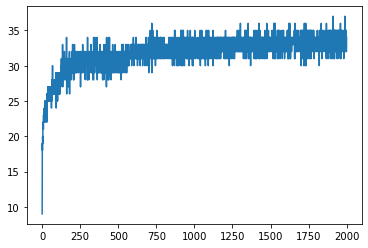

In [29]:
%matplotlib inline
# number of collisions - evolution
plt.plot(collisions_evo);

In [26]:
print('Number of collision per cell : \n', np.sum(arr_nb_colls, axis = (0)));

Number of collision per cell : 
 [[6178. 6820. 7611.]
 [7643. 6506. 6765.]
 [7567. 7201. 7417.]]


Mean proba : 0.3564872932560762
Mean distance : 0.0005209885235465581


<IPython.core.display.Javascript object>


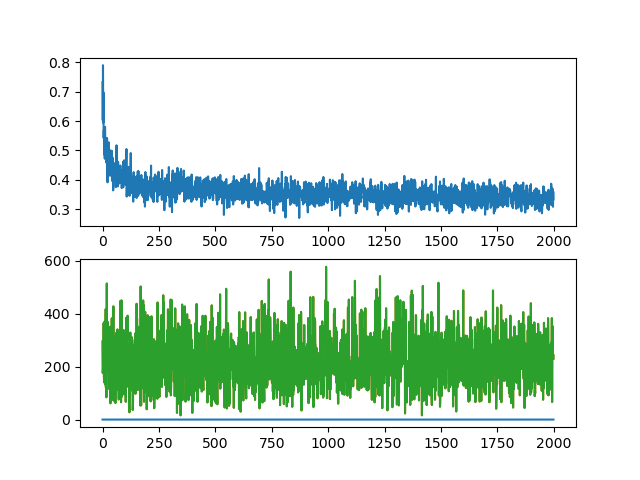

In [63]:
%matplotlib notebook
print('Mean proba : {}'.format(np.sum(monitors[:,1]/np.sum(monitors[:,2]))))
print('Mean distance : {}'.format(np.sum(monitors[:,0]/np.sum(monitors[:,2]))))

qty = monitors[:,2]
qty = np.where(qty == 0, 1e-14, qty)

fig, ax = plt.subplots(2)
ax[0].plot(monitors[:,1]/qty, label = 'proba')
ax[1].plot(monitors[:,0]/qty, label = 'distance')
plt.show()